# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

This time, using year, month, county as fixed effects. And interact year * county.

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [16]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [2]:
# local or gdrive
path_source = 'work'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in data

In [3]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-18.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]

# Data clean

Clean med data

In [4]:
# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + df2['patzip_year_month'].to_list() + df3['patzip_year_month'].to_list()
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')

df_med.head(3)

,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab
0,92392-2014-4,1.0,17.0,1.0,17.0,NaN,NaN
1,92336-2010-2,1.0,17.0,1.0,20.0,1.0,17.0
2,93266-2005-6,1.0,18.0,NaN,NaN,NaN,NaN


Join med data

In [5]:
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 'pediatric_vasculitis', 
  'number_of_visits_vasc', 'type_1_diabetes', 'number_of_visits_diab']
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

print(df.shape[0])

311163


Var transformations

In [6]:
# Create response variables, which is visits / population
df['y_hematopoietic'] = df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = df['number_of_visits_diab'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# First stage regression - Predict pm2.5 levels

- QQplot says the residuals are skewed right and have heavy tails (same with logged version, but less skewed).

In [7]:
# get data into right model form
y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month)', 
  data=df, return_type='dataframe')

RMSE: 4.323664445668356
                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     203.8
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:32:30   Log-Likelihood:            -8.9710e+05
No. Observations:              311163   AIC:                         1.797e+06
Df Residuals:                  309770   BIC:                         1.812e+06
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

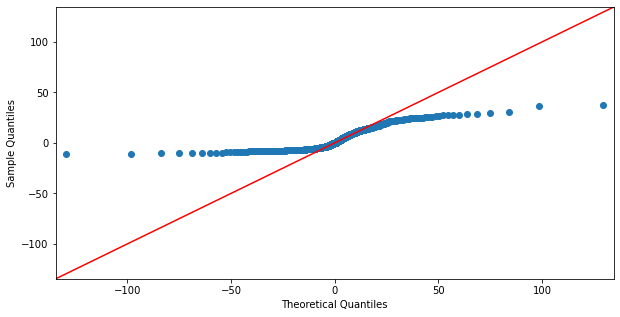

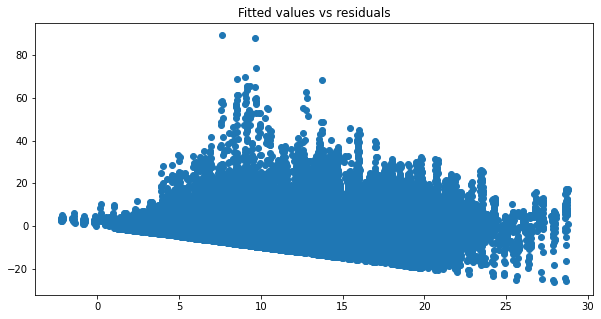

In [8]:
# rearrange cols a bit
X = X[['avg_wind_alignment_cosine'] + [i for i in X.columns if not re.search('avg_wind_alignment_cosine', i)]]
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_pm25'] = fit1.fittedvalues.values

# resid
resids = fit1.resid
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

#p-values
#fit1.pvalues

# rmse
rmse = np.mean(np.array(df['yhat_pm25'] - df['pm25']) ** 2) ** .5
print(f'RMSE: {rmse}')

# model summary
print(fit1.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted['fitted'], resids_and_fitted['resids'])
plt.title('Fitted values vs residuals')
plt.show()

<AxesSubplot:>

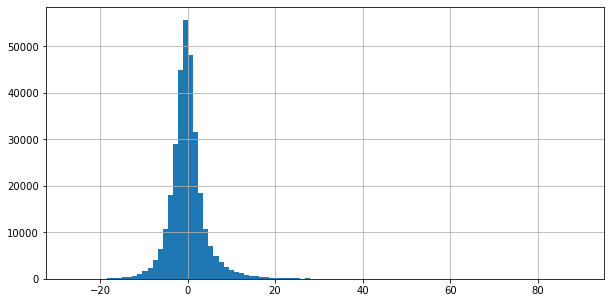

In [9]:
# histogram of the residuals
resids_and_fitted['resids'].hist(bins=100)

In [23]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

get_ols_res(fit1)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,avg_wind_alignment_cosine,0.097724,9.321278e-13,0.070900,0.124548
1,Intercept,15.544906,0.000000e+00,14.918460,16.171353
2,school_county_v2[T.Alpine],-7.060212,5.358238e-35,-8.181241,-5.939184
3,school_county_v2[T.Amador],-3.181852,1.950493e-30,-3.725683,-2.638021
4,school_county_v2[T.Butte],-3.490151,3.256192e-49,-3.953959,-3.026343
...,...,...,...,...,...
1456,year_trend:C(county_month)[T.12_Tulare],0.508208,5.555850e-29,0.419063,0.597352
1457,year_trend:C(county_month)[T.12_Tuolumne],0.386828,2.178166e-08,0.251377,0.522280
1458,year_trend:C(county_month)[T.12_Ventura],0.232862,7.682842e-07,0.140536,0.325189
1459,year_trend:C(county_month)[T.12_Yolo],0.117882,5.587518e-02,-0.002957,0.238721


# Second Stage Regression

- Stage 1 of the least squares regression: $\hat{x} = z \delta$.
  - $\hat{x}$ = Predicted pm2.5 amounts ($\hat{pm2.5}$). We'll use this predicted var to predict our final Y, health outcomes. 
  - $z$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 
  
- Stage 2 of the equation: $\hat{y} = \hat{x} \beta$
  - $\hat{y}$ = predicted medical outcome
  - $\hat{x}$ = predicted pm2.5 amt from the first stage. But we also should include the other exogenous vars. 

In [10]:
# dont need to re-run
# y, X = dmatrices('y_hematopoietic ~ yhat_pm25 + school_county_v2 + month + year_trend * C(county_month)', 
#   data=df, return_type='dataframe')
# X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]]

In [11]:
# drop instrument, and add x_hat to the X matrix
X = X.drop(columns='avg_wind_alignment_cosine')
X['yhat_pm25'] = df['yhat_pm25']
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]]

                            OLS Regression Results                            
Dep. Variable:        y_hematopoietic   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.111
Date:                Tue, 18 Oct 2022   Prob (F-statistic):          1.05e-111
Time:                        11:33:57   Log-Likelihood:             1.4632e+06
No. Observations:              311163   AIC:                        -2.924e+06
Df Residuals:                  309770   BIC:                        -2.909e+06
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

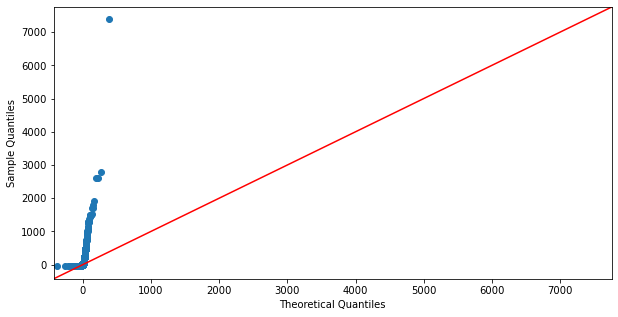

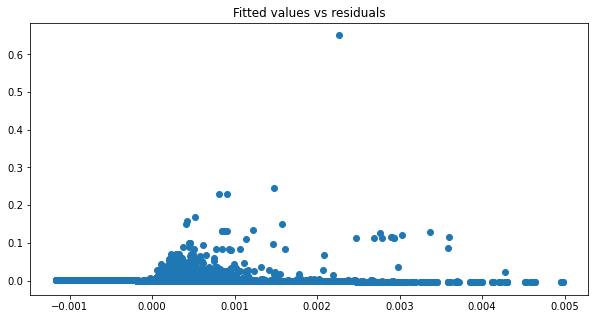

In [12]:
y = df['y_hematopoietic']
fit2_hema = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2_hema.resid
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

# p-value
# print(f'p-value: {fit2_hema.pvalues.to_frame().iloc[-1][0]}')

print(fit2_hema.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_hema['fitted'], resids_and_fitted_hema['resids'])
plt.title('Fitted values vs residuals')
plt.show()

In [13]:
# dont need to re-run
# y, X = dmatrices('y_vasculitis ~ yhat_pm25 + school_county_v2 + month + year_trend * C(county_month)', 
#   data=df, return_type='dataframe')
# X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]]

                            OLS Regression Results                            
Dep. Variable:           y_vasculitis   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.030
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           3.80e-99
Time:                        11:35:06   Log-Likelihood:             1.5950e+06
No. Observations:              311163   AIC:                        -3.187e+06
Df Residuals:                  309770   BIC:                        -3.172e+06
Df Model:                        1392                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

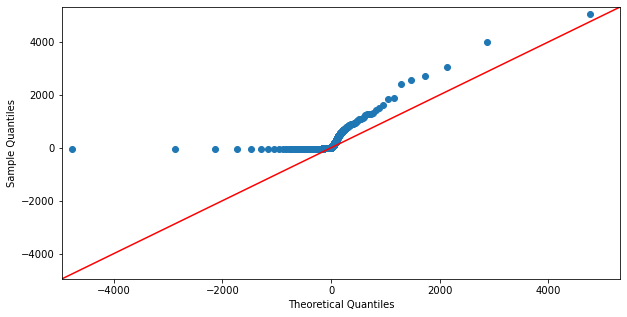

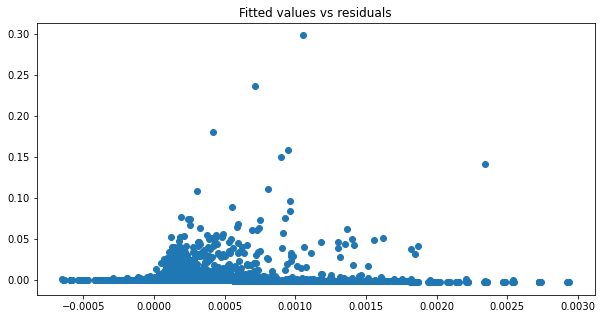

In [14]:
y = df['y_vasculitis']
fit2_vasc = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2_vasc.resid
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print(fit2_vasc.summary())

# p-value
# print(f'p-value: {fit2_vasc.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_vasc['fitted'], resids_and_fitted_vasc['resids'])
plt.title('Fitted values vs residuals')
plt.show()

In [15]:
y, X = dmatrices('y_diabetes ~ yhat_pm25 + year_trend + month * school_county_v2', data=df, return_type='dataframe')
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]]

                            OLS Regression Results                            
Dep. Variable:             y_diabetes   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.173
Date:                Tue, 18 Oct 2022   Prob (F-statistic):            0.00108
Time:                        11:35:45   Log-Likelihood:             1.1560e+06
No. Observations:              311163   AIC:                        -2.311e+06
Df Residuals:                  310465   BIC:                        -2.303e+06
Df Model:                         697                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

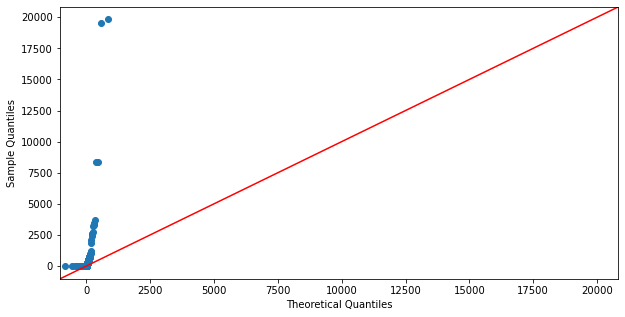

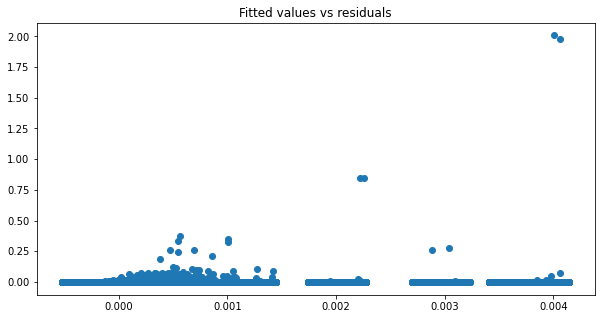

In [16]:
fit2_diab = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values 

resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print(fit2_diab.summary())

# p-value
# print(f'p-value: {fit2_diab.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(fit2_diab.resid, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_diab['fitted'], resids_and_fitted_diab['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# Results Summary
- Use these printouts to easily paste key stats onto our poster

In [17]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

In [25]:
print(get_ols_res(fit2_hema).head(3))

                     variable      coef   p_value  95_ci_lower  95_ci_upper
0                   yhat_pm25  0.000133  0.060778    -0.000006     0.000273
1                   Intercept -0.002065  0.066249    -0.004269     0.000139
2  school_county_v2[T.Alpine]  0.000939  0.107960    -0.000206     0.002085


In [24]:
print(get_ols_res(fit2_vasc).head(3))

                     variable      coef   p_value  95_ci_lower  95_ci_upper
0                   yhat_pm25 -0.000109  0.019557    -0.000200    -0.000017
1                   Intercept  0.001759  0.016829     0.000317     0.003202
2  school_county_v2[T.Alpine] -0.000815  0.033184    -0.001564    -0.000065


In [26]:
print(get_ols_res(fit2_diab).head(3))

      variable      coef   p_value  95_ci_lower  95_ci_upper
0    yhat_pm25  0.000041  0.000003     0.000024     0.000058
1    Intercept -0.000724  0.003002    -0.001202    -0.000246
2  month[T.10]  0.000145  0.623439    -0.000435     0.000726


# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


              wind_bearing   hema_resids   vasc_resids  diab_resids
wind_bearing  1.000000e+00 -1.236027e-16  1.155905e-16    -0.001890
hema_resids  -1.236027e-16  1.000000e+00  2.056838e-02     0.000579
vasc_resids   1.155905e-16  2.056838e-02  1.000000e+00     0.000652
diab_resids  -1.889548e-03  5.788436e-04  6.522964e-04     1.000000


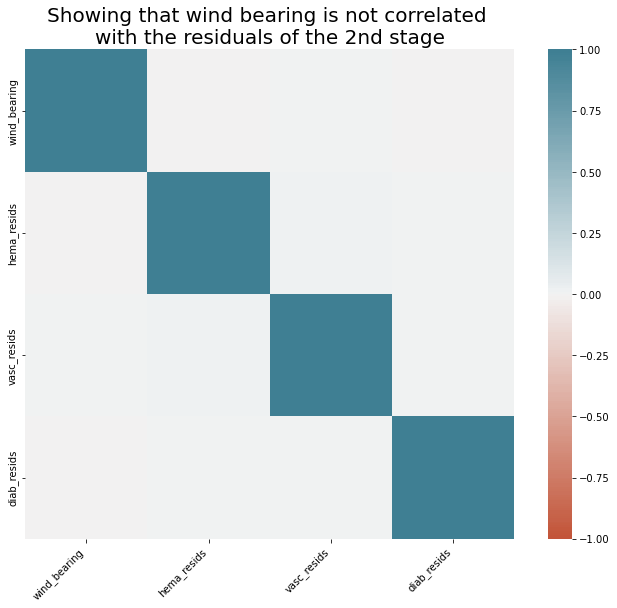

In [21]:
df_corr = pd.DataFrame({
  'wind_bearing': df['avg_wind_alignment_cosine'].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)

# First stage F-test

Run an F test with our instrument to study the impact on the pm2.5. 

In [22]:
# get data into right model form
y, X_null = dmatrices('pm25 ~ 1', data=df, return_type='dataframe')
y, X_instrument = dmatrices('pm25 ~ avg_wind_alignment_cosine', data=df, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,311162.0,1.114428e+07,0.0,NaN,NaN,NaN
1,311161.0,1.114275e+07,1.0,1526.706847,42.633231,6.612902e-11
